# Import Image Data and Generate FSM

In this notebook, I will import my images using Keras image generator and then create a first simple model using a sequential CNN with one hidden layer.  

### Imports

In [114]:
# imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# turn off warnings
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = FutureWarning)

# modelling
from keras.models import Sequential
from keras.layers import Dense, Flatten

# variable to root directory
parent_dir = '../../'

In [127]:
# create data generator object
datagen = ImageDataGenerator(validation_split = 0.2)

In [128]:
# import data
train_gen = datagen.flow_from_directory(parent_dir + 'data/seg_train/',
                                         batch_size = 64, subset = 'training')

val_gen = datagen.flow_from_directory(parent_dir + 'data/seg_train/', 
                                     batch_size = 64, subset = 'validation')
test_gen = datagen.flow_from_directory(parent_dir + 'data/seg_test/', 
                                        batch_size = 64)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [126]:
train_gen.__dict__

{'directory': '../../data/seg_train/',
 'image_data_generator': <keras.preprocessing.image.ImageDataGenerator at 0x654ea44e0>,
 'target_size': (256, 256),
 'color_mode': 'rgb',
 'data_format': 'channels_last',
 'image_shape': (256, 256, 3),
 'classes': array([0, 0, 0, ..., 5, 5, 5], dtype=int32),
 'class_mode': 'categorical',
 'save_to_dir': None,
 'save_prefix': '',
 'save_format': 'png',
 'interpolation': 'nearest',
 'subset': None,
 'samples': 14034,
 'num_classes': 6,
 'class_indices': {'buildings': 0,
  'forest': 1,
  'glacier': 2,
  'mountain': 3,
  'sea': 4,
  'street': 5},
 'filenames': ['buildings/0.jpg',
  'buildings/10006.jpg',
  'buildings/1001.jpg',
  'buildings/10014.jpg',
  'buildings/10018.jpg',
  'buildings/10029.jpg',
  'buildings/10032.jpg',
  'buildings/10056.jpg',
  'buildings/1009.jpg',
  'buildings/10113.jpg',
  'buildings/1012.jpg',
  'buildings/10126.jpg',
  'buildings/10144.jpg',
  'buildings/10151.jpg',
  'buildings/10161.jpg',
  'buildings/10165.jpg',
  'bui

In [120]:
image_, label_ = next(train_gen)

In [121]:
label_.shape

(64, 6)

In [59]:
path = parent_dir + 'data/seg_train/forest'
training_images = os.listdir(path)
training_array = []
for idx, image in enumerate(training_images):
    
    image_single_import = os.path.join(path, training_images[idx])
  
    image = Image.open(image_single_import)
    pixel  = np.asarray(image)
    training_array.append(pixel)

In [58]:
pixel.shape

(150, 150, 3)

In [28]:
train_gen.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

This is the result we expected so we assume this was done correctly.  

Check the shape of the datasets:

In [47]:
train_gen[0][0]

array([[[[130., 182., 222.],
         [130., 182., 222.],
         [130., 182., 222.],
         ...,
         [132., 184., 232.],
         [133., 185., 233.],
         [133., 185., 233.]],

        [[132., 181., 222.],
         [130., 182., 222.],
         [130., 182., 222.],
         ...,
         [134., 186., 233.],
         [134., 186., 233.],
         [133., 185., 232.]],

        [[133., 182., 223.],
         [133., 182., 223.],
         [131., 183., 223.],
         ...,
         [134., 187., 231.],
         [134., 187., 231.],
         [134., 187., 231.]],

        ...,

        [[  1.,   2.,   4.],
         [  1.,   2.,   4.],
         [  1.,   2.,   4.],
         ...,
         [ 88.,  95., 101.],
         [ 84.,  91.,  97.],
         [ 78.,  85.,  93.]],

        [[  1.,   2.,   4.],
         [  1.,   2.,   4.],
         [  1.,   3.,   2.],
         ...,
         [ 40.,  53.,  62.],
         [ 41.,  53.,  65.],
         [ 42.,  54.,  68.]],

        [[  1.,   5.,   4.],
       

## FSM:  Basic CNN Model

### Metric Discussion

Our aim for this model is that it classifies images as accurately as possible.  There is no real preference towards seeing less false negatives over false positives and visa versa since both means that it was a mis-classification either way, which we don't want.  For this reason, we will choose to optimise for accuracy.  

In [129]:
# create sequential model object:
fsm = Sequential()

# flatten shape to 100x100
fsm.add(Flatten(input_shape = (256, 256, 3)))

# create input layer:
fsm.add(Dense(units = 64, activation = 'relu', input_shape = (256, 3)))

# create 1 hidden layer:
fsm.add(Dense(units = 128, activation = 'relu'))

# create output layer:
fsm.add(Dense(units = 6, activation = 'softmax'))

# compile the model:
fsm.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [130]:
fsm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 196608)            0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_70 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_71 (Dense)             (None, 6)                 774       
Total params: 12,592,070
Trainable params: 12,592,070
Non-trainable params: 0
_________________________________________________________________


In [131]:
fsm_results = fsm.fit_generator(train_gen, epochs = 4, validation_data = val_gen)

Epoch 1/4
176/176 [==============================] - 45s 255ms/step - loss: 13.2211 - acc: 0.1795 - val_loss: 13.2325 - val_acc: 0.1790
Epoch 2/4
176/176 [==============================] - 41s 235ms/step - loss: 13.2306 - acc: 0.1791 - val_loss: 13.2325 - val_acc: 0.1790
Epoch 3/4
176/176 [==============================] - 42s 237ms/step - loss: 13.2290 - acc: 0.1792 - val_loss: 13.2325 - val_acc: 0.1790
Epoch 4/4
176/176 [==============================] - 41s 236ms/step - loss: 13.2338 - acc: 0.1789 - val_loss: 13.2325 - val_acc: 0.1790


In [132]:
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize = (10, 8))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();
    
    plt.figure(figsize = (10, 8))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show();

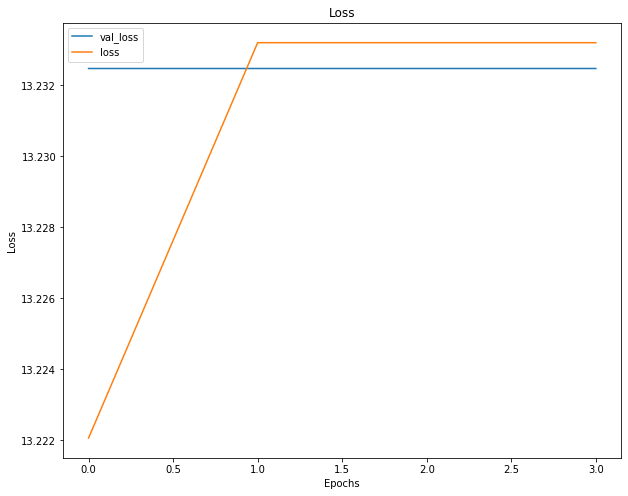

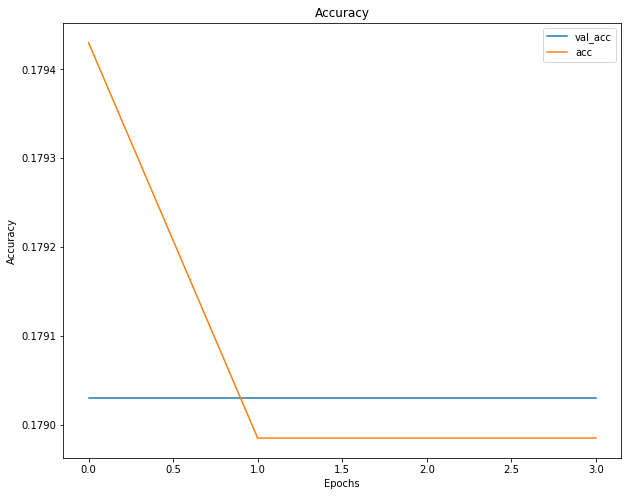

In [133]:
visualize_training_results(fsm_results)

In [134]:
fsm_results.history

{'val_loss': [13.23247352170196,
  13.232473456400438,
  13.232473653665453,
  13.232473587003483],
 'val_acc': [0.17902995731027932,
  0.1790299572252513,
  0.17902995728902232,
  0.1790299572252513],
 'loss': [13.222067534191101,
  13.233200328857476,
  13.233200379471002,
  13.23320033700999],
 'acc': [0.17943009795987597,
  0.17898486197950153,
  0.17898486201400113,
  0.1789848619901168]}